# Flopy Tutorial 2

In [1]:
import os
import sys
import numpy as np
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil

In [2]:
workspace = os.path.join('tutorial-2')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

In [4]:
# Assign name and create modflow model object
modelname = 'tutorial2'
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005', model_ws = workspace)

In [5]:
# Model domain and grid definition
Lx = 1000.
Ly = 1000.
ztop = 50.
zbot = 0
nlay = 1
nrow = 10
ncol = 10
delr = 100.446
delc = 101.100
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)
hk = 1.
vka = 1.
sy = 0.1
ss = 1.e-4
laytyp = 1
nper = 3
perlen = [1, 100, 100]
#nstp = [1, 100, 100]
steady = [True, False, False]

In [6]:
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:], nper=nper, perlen=perlen, 
                               #nstp=nstp, 
                               steady=steady,proj4_str = 'EPSG:31985',
                               #xul = 292147.853,
                               # yul = 9105709.477
                              )
flopy.export.shapefile_utils.model_attributes_to_shapefile('model.shp', mf, package_names = ['dis'])

wrote model.shp


In [7]:
# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 60. * np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [8]:
# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)

In [9]:
# Make list for stress period 1
stageleft = 60.
stageright = 60.
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp1), 'GHBs for stress period 1.')
print(condleft,condright)

# Make list for stress period 2
stageleft = 60.
stageright = 50.
condleft = hk * (stageleft - zbot) * delc
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print('Adding ', len(bound_sp2), 'GHBs for stress period 2.')

# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stress period 2 and apply it
# to the end of the simulation, if necessary
stress_period_data = {0: bound_sp1, 1: bound_sp2}

# Create the flopy ghb object
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)
print(condleft,condright)

Adding  20 GHBs for stress period 1.
6066.0 6066.0
Adding  20 GHBs for stress period 2.
6066.0 5055.0


In [10]:
# Create the well package
# Remember to use zero-based layer, row, column indices!
pumping_rate = -1000.
wel_sp1 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp2 = [[0, nrow/2 - 1, ncol/2 - 1, 0.]]
wel_sp3 = [[0, nrow/2 - 1, ncol/2 - 1, pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)

In [11]:
# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(mf, save_every = True, save_types=['SAVE HEAD', 'SAVE BUDGET'],
                             compact=True)

In [12]:
# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf,hclose=1e-02, rclose=1e-02)

In [13]:
# Write the MODFLOW model input files
mf.write_input()
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following  executable to run the model: C:\modflow\Packages\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: tutorial2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/01/18 15:28:57

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/01/18 15:28:57
 Elapsed run time:  0.042 Seconds

  Normal termination of simulation


Levels:  [50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60.]
Extent:  (50.223, 949.777, 50.55, 949.45)
*****Processing time:  1.0
Head statistics
  min:  60.0
  max:  60.0
  std:  0.0


c:\python36\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
c:\python36\lib\site-packages\matplotlib\quiver.py:665: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\python36\lib\site-packages\matplotlib\quiver.py:665: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\python36\lib\site-packages\matplotlib\quiver.py:717: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
c:\python36\lib\site-packages\matplotlib\quiver.py:731: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


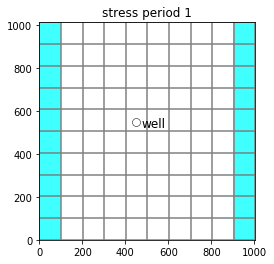

*****Processing time:  101.0
Head statistics
  min:  50.014416
  max:  59.991936
  std:  3.1595383


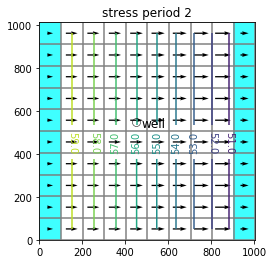

*****Processing time:  201.0
Head statistics
  min:  45.15981
  max:  59.98616
  std:  3.4659758


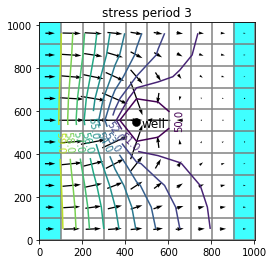

In [14]:
headobj = bf.HeadFile(os.path.join(workspace, modelname+'.hds'))
times = headobj.get_times()
cbb = bf.CellBudgetFile(os.path.join(workspace, modelname+'.cbc'))

# Setup contour parameters
levels = np.linspace(50, 60, 11)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
print('Levels: ', levels)
print('Extent: ', extent)

# Well point
wpt = ((float(ncol/2)-0.5)*delr, (float(nrow/2-1)+0.5)*delc)
wpt = (450., 550.)

# Make the plots
mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print('*****Processing time: ', time)
    head = headobj.get_data(totim=time)
    #Print statistics
    print('Head statistics')
    print('  min: ', head.min())
    print('  max: ', head.max())
    print('  std: ', head.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]
    fff = cbb.get_data(text='FLOW FRONT FACE', totim=time)[0]

    #Create the plot
    f = plt.figure()
    plt.subplot(1, 1, 1, aspect='equal')
    plt.title('stress period ' + str(iplot + 1))


    modelmap = flopy.plot.ModelMap(model=mf, layer=0)
    qm = modelmap.plot_ibound()
    lc = modelmap.plot_grid()
    qm = modelmap.plot_bc('GHB', alpha=0.5)
    cs = modelmap.contour_array(head, levels=levels)
    plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')
    quiver = modelmap.plot_discharge(frf, fff, head=head)


    mfc = 'None'
    if (iplot+1) == len(mytimes):
        mfc='black'
    plt.plot(wpt[0], wpt[1], lw=0, marker='o', markersize=8,
             markeredgewidth=0.5,
             markeredgecolor='black', markerfacecolor=mfc)
    plt.text(wpt[0]+25, wpt[1]-25, 'well', size=12)
    plt.show()

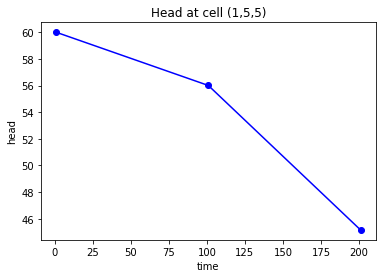

In [15]:
idx = (0, int(nrow/2) - 1, int(ncol/2) - 1)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time')
plt.ylabel('head')
plt.plot(ts[:, 0], ts[:, 1], 'bo-')
plt.show()